In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Wczytywanie charakterystyk profilu


In [3]:
#stałe
rho0=1.2255 #kg/m3
S=16.38 #m2
czmax=1.32  
m=670 #kg
g=9.81 #m/s
ca=0.863
ne0=1.461*pow(10,-5)

#Szacowanie liczby Reynoldsa
Vs1=np.sqrt((2*m*g)/(rho0*S*czmax))
Re1=(Vs1*ca)/ne0
Re1

ilkl=(12/19.3)
czkl=ilkl*1.66+(1-ilkl)*czmax
cxkl=ilkl*(0.0077)+(1-ilkl)*0.0056
deltaczkl=czkl-czmax
deltacxkl=cxkl-0.0056
deltacxkl

czmax+deltaczkl

1.5313989637305698

In [4]:
czalpha=pd.read_csv('../Projekt 2/profil/RE15CZALPHA.csv',sep=';',decimal=',',names=['alpha','cz'])
czcx=pd.read_csv('../Projekt 2/profil/RE15CZCX.csv',sep=';',decimal=',',names=['cx','cz'])
#sprawdź od kiedy maleje
#for x in range(len(czalpha)-1):
    #if czalpha['cz'][x+1]<czalpha['cz'][x]:
        #print(x)
#maleje od 44 indexu
#dropnięcie rzeczy od 44 indexu
czalpha=czalpha.iloc[0:44]
#obliczenie ainf dla liniowego zakresu
a=czalpha.loc[0:29]
#zamiana alpha deg na rad
a['alpharad']=np.nan
a['alpharad']=np.deg2rad(a.loc[:,'alpha'])
coefa=np.polyfit(a['alpharad'],a['cz'],1)
achuj=np.poly1d(coefa)
ainf=np.polyder(achuj)


<ipython-input-4-1fb4012fd391>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['alpharad']=np.nan
<ipython-input-4-1fb4012fd391>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['alpharad']=np.deg2rad(a.loc[:,'alpha'])


In [5]:
a

,alpha,cz,alpharad
0,-1.207031,0.176043,-0.021067
1,-1.046907,0.196150,-0.018272
2,-0.886783,0.216257,-0.015477
3,-0.686525,0.240385,-0.011982
4,-0.486064,0.262499,-0.008483
5,-0.285807,0.286626,-0.004988
6,-0.165815,0.302714,-0.002894
7,0.075391,0.322807,0.001316
8,0.316598,0.342901,0.005526
9,0.556988,0.371049,0.009721


In [6]:
#Połączenie dataframe'ów
df=czalpha.merge(czcx,on=['cz'],how='outer')

#dodanie nowego df'a z wartościami cz do cz=0
czekstr=np.linspace(-0.1,czalpha['cz'].min(),10)
czekstr=pd.DataFrame(czekstr,columns=['cz'])

#połączenie utworzonego df'a cz z głównym df'em
df=df.merge(czekstr,on=['cz'],how='outer')

#sortowanie wartości po cz (cz zawsze rośnie w tej funkcji)
df=df.sort_values(by='cz',ascending=True)
df=df.reset_index(drop=True)

#funkcja uzupełniająca alpha
coefalpha=np.polyfit(a['cz'],a['alpha'],1)
alpha=np.poly1d(coefalpha)
alphaint=lambda x:np.interp(x,czalpha['cz'],czalpha['alpha'])

#ekstrapolowanie wartości alpha poni
for x in range(len(df)):
    if df['cz'][x]<czalpha['cz'].min() and np.isnan(df['alpha'][x])==True:
        df['alpha'][x]=alpha(df['cz'][x])
    else:
        df['alpha'][x]=alphaint(df['cz'][x])

#ekstrapolowanie wartości Cx
#Funkcja ekstrapolująca cx (wielomian 8 stopnia)
coefcx=np.polyfit(czcx['cz'],czcx['cx'],4)
cx=np.poly1d(coefcx)
cxint=lambda x:np.interp(x,czcx['cz'],czcx['cx'])

#pętla która będzie decydować o przydzieleniu wartości funckji
#3 molzliwości po lewej stronie przedziału, po prawej stronie przedziału, w środku przedziału

for x in range(len(df)):
    #lewa strona
    if np.isnan(df['cx'][x])==True and df['cz'][x]<czcx['cz'].min():
        df['cx'][x]=cx(df['cz'][x])
    #środek
    elif np.isnan(df['cx'][x])==True and df['cz'][x]>czcx['cz'].min() and df['cz'][x]<czcx['cz'].max():
        df['cx'][x]=cxint(df['cz'][x])
    #prawa strona
    if np.isnan(df['cx'][x])==True and df['cz'][x]>czcx['cz'].max():
        df['cx'][x]=cx(df['cz'][x])
        
df=df.drop([106,107])
#Porządkowanie df'a
df=df.sort_values(by='cz',ascending=True)
df=df.reset_index(drop=True)

df.head(5)


,alpha,cz,cx
0,-3.797039,-0.100000,0.044520
1,-3.516350,-0.069329,0.037568
2,-3.235661,-0.038657,0.031553
3,-2.954972,-0.007986,0.026392
4,-2.674283,0.022686,0.022003


In [7]:
#dodanie charakterystyk z klapą
df['czkl']=df['cz']+deltaczkl
df['cxkl']=df['cx']+deltacxkl

In [8]:
#Zapisanie Charakterystyk ekstrapolowanych dla Re=1.5*10^6
df.to_excel('ekstrapolowanyprofil.xlsx')

In [9]:
#Wszytskie obliczenia dla profilu bez klapy

#obliczenie poprawki na liczbę Reynoldsa
cxmin1=df['cx'].min()
cxmin2=cxmin1*pow((Re1/pow(10,7)),0.11)
cxmin2
df['deltacxre']=(cxmin2-cxmin1)*(1-np.abs(df['cz']/czmax))
df['cxprim']=df['cx']+df['deltacxre']
beta25=np.deg2rad(3)

#dane potrzebne do przeliczenia wsp. galuerta
wydl=24.4 #do zmiany
ainf
wydla=wydl/ainf
zbiez=0.28
#współczynniki glauerta
#tau1
tau1=np.poly1d([0.023,-0.103,0,0.25])
print(tau1)
tau1=tau1(wydla)[0]
#tau2
tau2=np.poly1d([-0.18,1.52,-3.51,3.5,-1.33,0.17])
tau2=tau2(zbiez)
#tau
tau=(tau1*tau2)/0.17

#delta1
delta1=np.poly1d([0.0537,-0.005])
delta1=delta1(wydla)[0]

#delta2
delta2=np.poly1d([-0.43,1.83,-3.06,2.56,-1,0.148])
delta2=delta2(zbiez)

#delta3
delta3=(-2.2*pow(10,-7)*pow(wydl,3)+pow(10,-7)*pow(wydl,2)+1.6*pow(10,-5))*pow(beta25,3)+1

#delta
delta=(delta1*delta2*delta3)/0.048

df['cxi']=(np.power(df['cz'],2)/(np.pi*wydl))*(1+delta)

cxtech=0.15*df['cxprim'].min()

df['cxp']=df['cxprim']+cxtech+df['cxi']

df['alphaindrad']=(df['cz'])/(np.pi*wydl)*(1+tau)
df['alphaind']=np.rad2deg(df['alphaindrad'])
df['alphaplata']=df['alpha']+df['alphaind']




       3         2
0.023 x - 0.103 x + 0.25


In [10]:
#Wszytskie obliczenia dla profilu z klapą

#obliczenie poprawki na liczbę Reynoldsa
cxmin1=df['cxkl'].min()
cxmin2=cxmin1*pow((Re1/pow(10,7)),0.11)
cxmin2
df['deltacxrekl']=(cxmin2-cxmin1)*(1-np.abs(df['czkl']/1.66))
df['cxprimkl']=df['cxkl']+df['deltacxrekl']
beta25=np.deg2rad(3)

#dane potrzebne do przeliczenia wsp. galuerta
wydl=24.4 #do zmiany
ainf
wydla=wydl/ainf
zbiez=0.28
#współczynniki glauerta
#tau1
tau1=np.poly1d([0.023,-0.103,0,0.25])
print(tau1)
tau1=tau1(wydla)[0]
#tau2
tau2=np.poly1d([-0.18,1.52,-3.51,3.5,-1.33,0.17])
tau2=tau2(zbiez)
#tau
tau=(tau1*tau2)/0.17

#delta1
delta1=np.poly1d([0.0537,-0.005])
delta1=delta1(wydla)[0]

#delta2
delta2=np.poly1d([-0.43,1.83,-3.06,2.56,-1,0.148])
delta2=delta2(zbiez)

#delta3
delta3=(-2.2*pow(10,-7)*pow(wydl,3)+pow(10,-7)*pow(wydl,2)+1.6*pow(10,-5))*pow(beta25,3)+1

#delta
delta=(delta1*delta2*delta3)/0.048

df['cxikl']=(np.power(df['czkl'],2)/(np.pi*wydl))*(1+delta)

cxtech=0.15*df['cxprimkl'].min()

df['cxpkl']=df['cxprimkl']+cxtech+df['cxikl']

df['alphaindradkl']=(df['czkl'])/(np.pi*wydl)*(1+tau)
df['alphaindkl']=np.rad2deg(df['alphaindradkl'])
df['alphaplatakl']=df['alpha']+df['alphaindkl']

       3         2
0.023 x - 0.103 x + 0.25


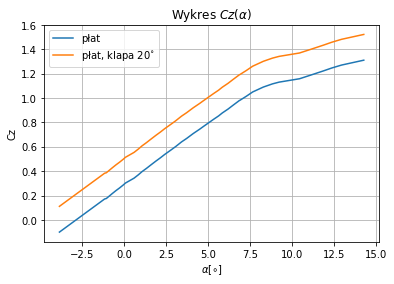

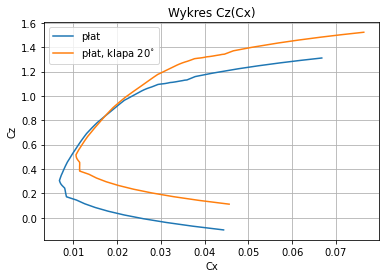

In [11]:
czal=plt.figure()
plt.plot(df['alphaplata'],df['cz'],label='płat')
plt.plot(df['alphaplata'],df['czkl'],label='płat, klapa $20^{\circ}$')
plt.xlabel('$\\alpha [\circ]$')
plt.ylabel('Cz')
plt.grid()
plt.title('Wykres $Cz(\\alpha)$')
plt.legend()
plt.savefig('czalpha.png',dpi=1000)


czceiks=plt.figure()
plt.plot(df['cxp'],df['cz'],label='płat')
plt.plot(df['cxpkl'],df['czkl'],label='płat, klapa $20^{\circ}$')
plt.grid()
plt.title('Wykres Cz(Cx)')
plt.xlabel('Cx')
plt.ylabel('Cz')
plt.legend()
plt.savefig('czcx.png',dpi=1000)

In [17]:
f=ainf[0]/(1+(ainf[0]/(np.pi*wydl)))*(1+tau)
f
df.to_excel('Projekt2finalV2.xlsx',index=False)
print(df['cx'].min())

0.0056948002902714
